# Importing and Settings

In [270]:
!pip install pennylane

In [271]:
import tensorflow as tf
import pennylane as qml
from pennylane import numpy as np
from pennylane.templates import RandomLayers
import matplotlib.pyplot as plt
from tensorflow import keras
from pennylane.optimize import AdamOptimizer, GradientDescentOptimizer
%matplotlib inline

In [272]:
n_epochs = 30   # Number of optimization epochs
n_layers = 1    # Number of random layers
n_train = 50    # Size of the train dataset
n_test = 30     # Size of the test dataset

SAVE_PATH = "quanvolution/" # Data saving folder
PREPROCESS = False           # If False, skip quantum processing and load data from SAVE_PATH
np.random.seed(0)           # Seed for NumPy random number generator
tf.random.set_seed(0)

In [273]:
mnist_dataset = keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist_dataset.load_data()

# Reduce dataset size
train_images = train_images[:n_train]
train_labels = train_labels[:n_train]
test_images = test_images[:n_test]
test_labels = test_labels[:n_test]

#print(train_labels)
#print(len(train_labels))

one_hot_vector = np.zeros((train_labels.size, train_labels.max() + 1))
one_hot_vector[np.arange(train_labels.size), train_labels] = 1

print(one_hot_vector.shape)
print(one_hot_vector[0])

# Normalize pixel values within 0 and 1
train_images = train_images / 255
test_images = test_images / 255

# Add extra dimension for convolution channels
train_images = np.array(train_images[..., tf.newaxis], requires_grad=False)
test_images = np.array(test_images[..., tf.newaxis], requires_grad=False)

(50, 10)
[0. 0. 0. ... 0. 0. 0.]


# Density Matrices

In [274]:
def density_matrix(state):
    """Calculates the density matrix representation of a state.

    Args:
        state (array[complex]): array representing a quantum state vector

    Returns:
        dm: (array[complex]): array representing the density matrix
    """
    # Ensure state is a numpy array and calculate the outer product
    state = np.asarray(state)
    return np.outer(state, np.conj(state))

dm_labels = density_matrix(one_hot_vector)
np.set_printoptions(threshold=3) #np.inf for whole array
print(dm_labels.shape)
print(dm_labels)

(500, 500)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


# Initializing Qubits

In [290]:
# Simulating 4 qubits.
dev = qml.device("default.qubit", wires=4)
# Random circuit parameters
rand_params = np.random.uniform(high=2 * np.pi, size=(n_layers, 4))
# Qnode represents the quantum circuit consisting of:
# 1. an embedding later of local Ry rotations (with angles scaled by a factor of pi)
# 2. a random circuit n_layers
# 3. a final measurement in the computational basis, estimating 4 expectation values.

which = 1

if which == 1:
#attempt 1
  @qml.qnode(dev)
  def circuit(params, rand_params):
      # Random quantum circuit
      RandomLayers(rand_params, wires=list(range(4)))

      # Encoding of 4 classical input values (re-uploading)
      for i in range(20):
        for j in range(4):
            qml.RY(params[j][0]*np.pi, wires=j) # Use parameters for Rot gates
        for k in range(3):
            qml.CNOT(wires=[k, k+1])
        qml.CNOT(wires=[3,0])

        # Measurement producing 4 classical output values
        return [qml.expval(qml.PauliZ(wires=j)) for j in range(4)]

elif which == 2:
#attempt 2
  @qml.qnode(dev)
  def circuit(params, rand_params, y_2x2):
      # Random quantum circuit
      RandomLayers(rand_params, wires=list(range(4)))

      # Encoding of 4 classical input values (re-uploading)
      for j in range(4):
          qml.RY(params[j][0]*np.pi, wires=j) # Use parameters for Rot gates
          #qml.PauliZ(wires=j)
          for k in range(3):
              qml.CNOT(wires=[k, k+1])
          qml.CNOT(wires=[3,0])

      # Measurement producing 4 classical output values
      return [qml.expval(qml.Hermitian(y_2x2, wires=[j])) for j in range(4)]

In [276]:
# Definition of the convolution scheme:
# 1. the image is divided into squares of 2x2 pixels
# 2. each square is processed by the quantum circuit
# 3. the e4 expectation values are mapped into 4 different channels of a single output pixel

# This process halves the resolution of the input image. In the standard language of CNN, this qould correspond to
# a convolution with a 2x2 kernel and a stride equal to 2

if which == 1:
  def quanv(image):
      """Convolves the input image with many applications of the same quantum circuit."""
      out = np.zeros((14, 14, 4))

      # Loop over the coordinates of the top-left pixel of 2X2 squares
      for j in range(0, 28, 2):
          for k in range(0, 28, 2):
              # Process a squared 2x2 region of the image with a quantum circuit
              q_results = circuit(
                  [
                      [image[j, k, 0], 0, 0], # Pass parameters for Rot gates
                      [image[j, k + 1, 0], 0, 0],
                      [image[j + 1, k, 0], 0, 0],
                      [image[j + 1, k + 1, 0], 0, 0]
                  ]
                  ,
                  rand_params # Pass parameters for RandomLayers
              )
              # Assign expectation values to different channels of the output pixel (j/2, k/2)
              for c in range(4):
                  out[j // 2, k // 2, c] = q_results[c]
      return out

if which == 2:
  def quanv(image):
    """Convolves the input image with many applications of the same quantum circuit."""
    out = np.zeros((14, 14, 4))

    # Loop over the coordinates of the top-left pixel of 2X2 squares
    for j in range(0, 28, 2):
        for k in range(0, 28, 2):
            # Extract the corresponding 2x2 density matrix from dm_labels
            y_2x2 = dm_labels[j:j+2, k:k+2]

            # Process a squared 2x2 region of the image with a quantum circuit
            q_results = circuit(
                [
                    [image[j, k, 0], 0, 0], # Pass parameters for Rot gates
                    [image[j, k + 1, 0], 0, 0],
                    [image[j + 1, k, 0], 0, 0],
                    [image[j + 1, k + 1, 0], 0, 0]
                ]
                ,
                rand_params # Pass parameters for RandomLayers
                ,
                y_2x2 # Pass the 2x2 density matrix
            )
            # Assign expectation values to different channels of the output pixel (j/2, k/2)
            for c in range(4):
                out[j // 2, k // 2, c] = q_results[c]
    return out

# Preprocessing (I didn't touch anything beneath this code)

In [291]:
# Quantum convolution layer is not trained. "pre-processing" layer to all the images of our dataset.
# The classical model will be directly trained on the pre-processed dataset, avoiding unnecessary repetitions of
# quantum computations
if PREPROCESS == False:
    q_train_images = []
    print("Quantum pre-processing of train images:")
    for idx, img in enumerate(train_images):
        print("{}/{}        ".format(idx + 1, n_train), end="\r")
       #quanv(img).squeeze()
        q_train_images.append(quanv(img))
    q_train_images = np.asarray(q_train_images)

    q_test_images = []
    print("\nQuantum pre-processing of test images:")
    for idx, img in enumerate(test_images):
        print("{}/{}        ".format(idx + 1, n_test), end="\r")
        #quanv(img).squeeze()
        q_test_images.append(quanv(img))

    q_test_images = np.asarray(q_test_images)

if PREPROCESS == True:
    q_train_images = np.load(SAVE_PATH + "q_train_images.npy")
    q_test_images = np.load(SAVE_PATH + "q_test_images.npy")

Quantum pre-processing of train images:

Quantum pre-processing of test images:


# Visualizing Data

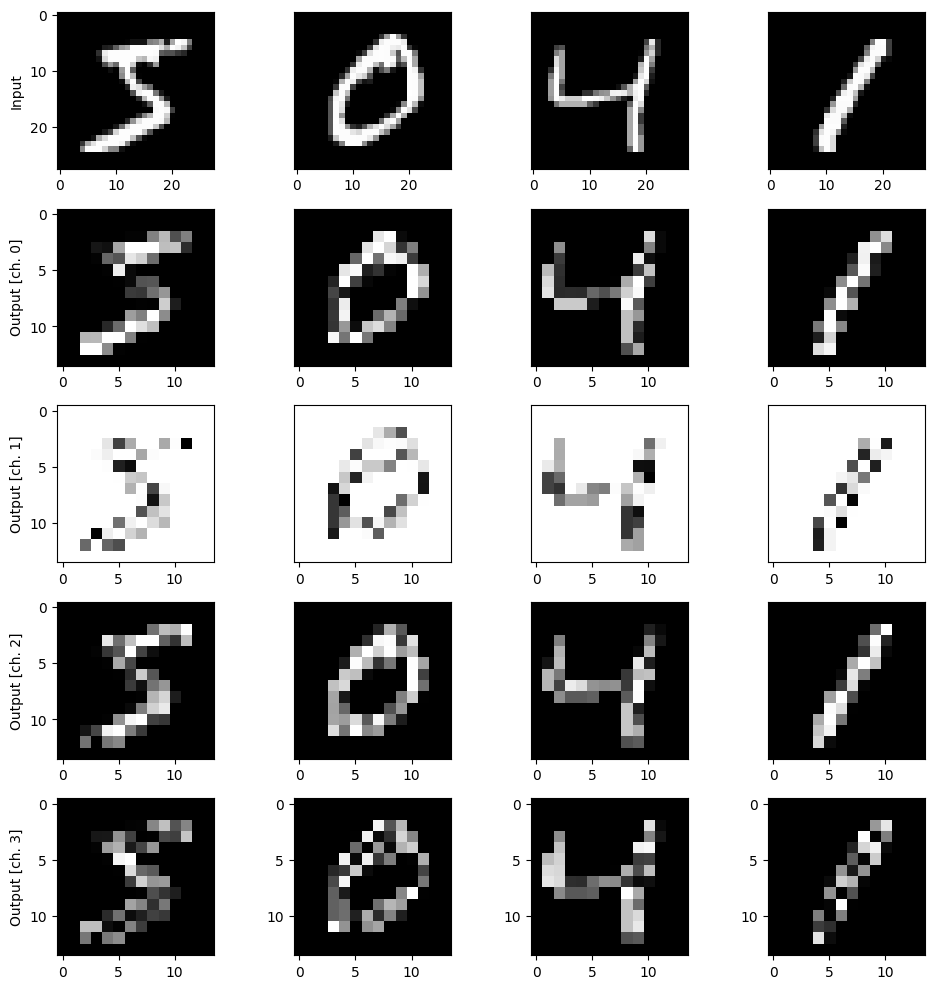

In [292]:
n_samples = 4
n_channels = 4
fig, axes = plt.subplots(1 + n_channels, n_samples, figsize=(10, 10))
for k in range(n_samples):
    axes[0, 0].set_ylabel("Input")
    if k != 0:
        axes[0, k].yaxis.set_visible(False)
    axes[0, k].imshow(train_images[k, :, :, 0], cmap="gray")

    # Plot all output channels
    for c in range(n_channels):
        axes[c + 1, 0].set_ylabel("Output [ch. {}]".format(c))
        if k != 0:
            axes[c, k].yaxis.set_visible(False)
        axes[c + 1, k].imshow(q_train_images[k, :, :, c], cmap="gray")

plt.tight_layout()
plt.show()

In [293]:
# After the application of the quantum convolution layer we feed the resulting features into a classical nn
# and trained to classify the 10 different digits of the MNIST dataset

# Simple model: fully connected 10 output nodes with a softmax activations function

# compiled with a stochastic-gradient-descent optimizer, and a cross-entropy loss function

def MyModel():
    """Initializes and returns a custom Keras model
    which is ready to be trained."""
    model = keras.models.Sequential([
        keras.layers.Flatten(),
        keras.layers.Dense(10, activation="softmax")
    ])

    model.compile(
        optimizer='adam',
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model


# Getting Results

In [294]:
# train and validate the model (has already been pre-processed by a quantum convolution)
q_model = MyModel()

q_history = q_model.fit(
    q_train_images,
    train_labels,
    validation_data=(q_test_images, test_labels),
    batch_size=4,
    epochs=n_epochs,
    verbose=2,
)

Epoch 1/30
13/13 - 1s - 67ms/step - accuracy: 0.1000 - loss: 2.8288 - val_accuracy: 0.2000 - val_loss: 2.2031
Epoch 2/30
13/13 - 0s - 9ms/step - accuracy: 0.2000 - loss: 2.1715 - val_accuracy: 0.1667 - val_loss: 2.2029
Epoch 3/30
13/13 - 0s - 9ms/step - accuracy: 0.4000 - loss: 1.9675 - val_accuracy: 0.3000 - val_loss: 2.0983
Epoch 4/30
13/13 - 0s - 9ms/step - accuracy: 0.5400 - loss: 1.7766 - val_accuracy: 0.3333 - val_loss: 1.9902
Epoch 5/30
13/13 - 0s - 9ms/step - accuracy: 0.6200 - loss: 1.5997 - val_accuracy: 0.4667 - val_loss: 1.9076
Epoch 6/30
13/13 - 0s - 9ms/step - accuracy: 0.7400 - loss: 1.4413 - val_accuracy: 0.5667 - val_loss: 1.8331
Epoch 7/30
13/13 - 0s - 9ms/step - accuracy: 0.8200 - loss: 1.2984 - val_accuracy: 0.6333 - val_loss: 1.7669
Epoch 8/30
13/13 - 0s - 11ms/step - accuracy: 0.8800 - loss: 1.1720 - val_accuracy: 0.6333 - val_loss: 1.7076
Epoch 9/30
13/13 - 0s - 9ms/step - accuracy: 0.9600 - loss: 1.0578 - val_accuracy: 0.6000 - val_loss: 1.6530
Epoch 10/30
13/13

In [295]:
# a classical instance to later compare with the quantum convolution layer
c_model = MyModel()

c_history = c_model.fit(
    train_images,
    train_labels,
    validation_data=(test_images, test_labels),
    batch_size=4,
    epochs=n_epochs,
    verbose=2,
)

Epoch 1/30
13/13 - 1s - 65ms/step - accuracy: 0.1400 - loss: 2.2371 - val_accuracy: 0.1333 - val_loss: 2.2945
Epoch 2/30
13/13 - 0s - 9ms/step - accuracy: 0.4000 - loss: 1.8623 - val_accuracy: 0.2333 - val_loss: 2.1049
Epoch 3/30
13/13 - 0s - 9ms/step - accuracy: 0.5800 - loss: 1.5871 - val_accuracy: 0.3000 - val_loss: 1.9379
Epoch 4/30
13/13 - 0s - 9ms/step - accuracy: 0.7800 - loss: 1.3564 - val_accuracy: 0.4333 - val_loss: 1.7972
Epoch 5/30
13/13 - 0s - 9ms/step - accuracy: 0.8400 - loss: 1.1647 - val_accuracy: 0.5333 - val_loss: 1.6822
Epoch 6/30
13/13 - 0s - 10ms/step - accuracy: 0.9600 - loss: 1.0065 - val_accuracy: 0.5333 - val_loss: 1.5892
Epoch 7/30
13/13 - 0s - 9ms/step - accuracy: 0.9600 - loss: 0.8756 - val_accuracy: 0.5333 - val_loss: 1.5137
Epoch 8/30
13/13 - 0s - 9ms/step - accuracy: 0.9600 - loss: 0.7670 - val_accuracy: 0.5333 - val_loss: 1.4515
Epoch 9/30
13/13 - 0s - 9ms/step - accuracy: 1.0000 - loss: 0.6762 - val_accuracy: 0.5667 - val_loss: 1.3997
Epoch 10/30
13/13

## Plotting

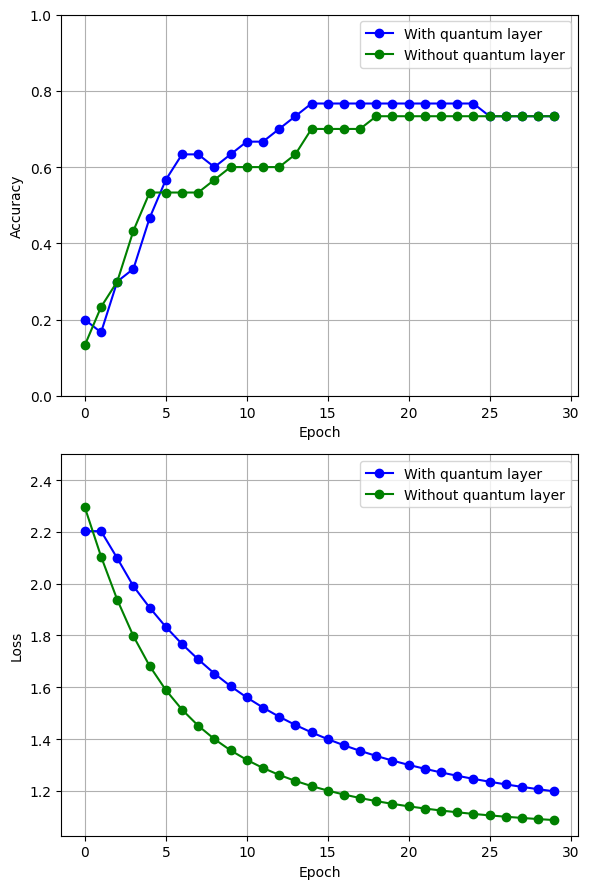

In [296]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 9))

ax1.plot(q_history.history["val_accuracy"], "-ob", label="With quantum layer")
ax1.plot(c_history.history["val_accuracy"], "-og", label="Without quantum layer")
ax1.set_ylabel("Accuracy")
ax1.set_ylim([0, 1])
ax1.set_xlabel("Epoch")
ax1.grid()
ax1.legend()

ax2.plot(q_history.history["val_loss"], "-ob", label="With quantum layer")
ax2.plot(c_history.history["val_loss"], "-og", label="Without quantum layer")
ax2.set_ylabel("Loss")
ax2.set_ylim(top=2.5)
ax2.set_xlabel("Epoch")
ax2.grid()
ax2.legend()
plt.tight_layout()
plt.show()